In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import sys
from IPython.display import clear_output
import pandas as pd
import random
from utils import get_chars, get_words
from highlight import HighlightWords
from keras.models import load_model

Using TensorFlow backend.


In [2]:
def plot_img(img, figsize=(20, 20)):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')

In [3]:
def process_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY_INV)[1]
    return img

In [4]:
def read_imgs(path, process=True):
    filenames = os.listdir(path)
    if process:
        imgs = [process_img(path + name) for name in filenames if '.jpg' in name or '.png' in name]
    else:
        imgs = [cv2.imread(path + name) for name in filenames if '.jpg' in name or '.png' in name]
    return imgs

In [5]:
def read_one_img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY_INV)[1]
    img = cv2.resize(img, (28, 28))
    
    return img

In [6]:
def gen_alphabet():
    small = [chr(i) for i in range(ord('a'), ord('z')+1)]
    big = [chr(i)+'_' for i in range(ord('A'), ord('Z')+1)]
    flatten = lambda l: [item for sublist in l for item in sublist]
    alphabet = flatten(zip(big, small))
    symbols = ['point', 'dash', 'comma', '!', '?', 'colon', 'semicolon', '>', 
               '<', 'equals', 'ampersant', 'hash', 'dollar', 'percent', '^',
               'and', 'asterics', 'round_open', 'round_close',
              'plus', 'backslash', 'slash', 'square_open', 'square_close', 'curly_open', 'curly_close']
    numbers = range(10)
    for symbol in symbols:
        alphabet.append(symbol)
    for number in numbers:
        alphabet.append(number)
    
    return alphabet
alphabet = gen_alphabet()

In [7]:
def indxs_to_alphabet():
    alphabet = gen_alphabet()
    res = []
    indx = 0
    for i in range(len(alphabet)):
        if i <= 51:
            if not i % 2:
                res.append(indx)
                res.append(indx)
                indx += 1
        else:
            res.append(indx)
            indx += 1
    
    alphabet2 = [chr(i) for i in range(ord('A'), ord('Z')+1)]
    symbols = ['point', 'dash', 'comma', '!', '?', 'colon', 'semicolon', '>', 
                   '<', 'equals', 'ampersant', 'hash', 'dollar', 'percent', '^',
                   'and', 'asterics', 'round_open', 'round_close',
                  'plus', 'backslash', 'slash', 'square_open', 'square_close', 'curly_open', 'curly_close']
    numbers = range(10)
    for symbol in symbols:
        alphabet2.append(symbol)
    for number in numbers:
        alphabet2.append(number)
    
    return res, alphabet2

res, alphabet2 = indxs_to_alphabet()

In [8]:
def normalize_images(images):
    H, W = 28, 28
    images = np.reshape(images, (-1, H * W))
    numerator = images - np.expand_dims(np.mean(images, 1), 1)
    denominator = np.expand_dims(np.std(images, 1), 1)
    return np.reshape(numerator / (denominator + 1e-7), (-1, H, W))

In [9]:
def resize(img, cordinates):
    [x, y, w, h] = cordinates
    temp_img = img[y:y+h, x:x+w]
    
    max_ = max(w, h)
    temp_img = cv2.copyMakeBorder(temp_img, (max_-h)//2, (max_-h)//2, (max_-w)//2, (max_-w)//2,
                                  cv2.BORDER_CONSTANT, value=(0, 0, 0))
    
    resized = cv2.resize(temp_img, (28, 28), interpolation=cv2.INTER_CUBIC)
    return resized

In [10]:
def get_accuracy(model, imgs, words):
    correct = 0
    wrong = 0
    imgs = []
    for i, example in enumerate(words):
        for word, (x, y, w, h) in enumerate(example):
            temp_img = imgs[i][y:y+h, x:x+w]
#             print(temp_img)
            temp_img = resize(imgs[i], (x, y, w, h))
            temp_img = normalize_images(temp_img)
            
            if predicted == word:
                correct += 1
            else:
                wrong += 1
                
    accuracy = correct / (correct+wrong)
    return accuracy

In [11]:
class Dataset:
    def __init__(self):
        self._path = 'course_project/train/{}/{}.jpg'
        self._font_names = [ name for name in os.listdir('course_project/train/') if '.' not in name]
        self._indxs = np.zeros((49, 88))
        self._indxs[:] = np.arange(88)
        self._last_batch = None
        
    def gen_batches(self, seed=None):
        np.random.seed(seed)
        for row in range(49):
            self._indxs[row] = np.random.randint(49, size=88)
        self._last_batch = 0
    
    def get_batch(self):
        X = np.zeros((88, 28, 28, 1))
        y = np.zeros((88, 62))

        indx = 0
        for j, val in enumerate(self._indxs[self._last_batch+1]):
            path = self._path.format(self._font_names[int(val)], alphabet[j])
            X[indx] = read_one_img(path).reshape((28, 28, 1))
            y[indx][temp[j]] = 1
                
            indx += 1
        self._last_batch += 1
        
        indxs = np.random.permutation(88)
        
        return X[indxs], y[indxs]

In [12]:
model = load_model('course_project/model_more_classes2.h5')

W0826 15:56:33.960611 4520105408 deprecation_wrapper.py:119] From /Users/svatoslavdarmograj/Documents/ml/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0826 15:56:34.050845 4520105408 deprecation_wrapper.py:119] From /Users/svatoslavdarmograj/Documents/ml/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0826 15:56:34.121949 4520105408 deprecation_wrapper.py:119] From /Users/svatoslavdarmograj/Documents/ml/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0826 15:56:34.122524 4520105408 deprecation_wrapper.py:119] From /Users/svatoslavdarmograj/Documents/ml/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_sess

In [12]:
path = 'course_project/alphabet/'
imgs = read_imgs(path)

In [13]:
%%time
words = []
# chars = []
for img in imgs:
    temp_words = get_words(img)
#     chars.append(get_chars(img, temp_words))
    words.append(temp_words)

CPU times: user 42.6 ms, sys: 1.94 ms, total: 44.5 ms
Wall time: 53.7 ms


In [15]:
alphabet2 = [chr(i) for i in range(ord('A'), ord('Z')+1)]
symbols = [".", "-", ",", "!", "?", ":", ";", ">", 
               "<", "=", "@", "#", "$", "%", "^",
               "&", "*", "(", ")",
              "+", "\\", "/", "[", "]", "{", "}"]
numbers = range(10)
for symbol in symbols:
    alphabet2.append(symbol)
for number in numbers:
    alphabet2.append(number)

In [16]:
# path_to_save = 'course_project/train/{}/'
# filenames = [name for name in os.listdir('course_project/alphabet/') if 'DS' not in name]
# for i, font in enumerate(words):
#     for word, cordinates in zip(alphabet, font):
#         img = resize(imgs[i], cordinates)
#         save_img(path_to_save.format(filenames[i][:-4]), img, str(word)+'.jpg')

Predicted: O


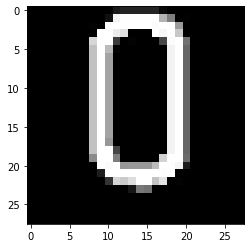

In [17]:
n = 23
# word = 23
word = 28
x, y, w, h = words[n][word]
temp = resize(imgs[n], (x, y, w, h))
temp = normalize_images(temp)
plt.imshow(np.reshape(temp, (28, 28)), cmap='gray')
temp = np.reshape(temp, (1, 28, 28, 1))
print('Predicted: {}'.format(alphabet2[np.argmax(model.predict(temp))]))

Predicted: 0


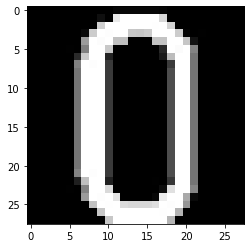

In [18]:
n = 23
# word = 23
word = 78
x, y, w, h = words[n][word]
temp = resize(imgs[n], (x, y, w, h))
temp = normalize_images(temp)
plt.imshow(np.reshape(temp, (28, 28)), cmap='gray')
temp = np.reshape(temp, (1, 28, 28, 1))
print('Predicted: {}'.format(alphabet2[np.argmax(model.predict(temp))]))

In [67]:
class HighlightWords:
    def __init__(self, model):
#         self._model = load_model('course_project/model_more_classes2.h5');
        self._model = model
        self._orig_img = None
        self._text = ''
        self._bboxes = None
        self._most_frequent_word = None
#         self._alphabet = gen_alphabet()
        self._alphabet = alphabet2
        print('Initialized')
        
    def _find_most_frequent(self):
        pass
    
    def _get_bboxes(self):
        words = get_words(self._thresholded_img)
        chars = get_chars(self._thresholded_img, words)
        self._bboxes = chars

    def _get_prediction(self):
        for i, word in enumerate(self._bboxes.values()):
            print('Word: {}'.format(i))
            for j, character_bbox in enumerate(word['cordinates']):
                img = resize(self._thresholded_img, character_bbox)
                img = normalize_images(img)

                img = img.reshape((1, 28, 28, 1))
                prediction = model.predict(img)
                decoded = self._alphabet[np.argmax(prediction)]
                
                self._text += str(decoded)
                
            self._text += ' '
            
            
    def fit(self, img):
        self._orig_img = img
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY_INV)[1]
        self._thresholded_img = img
        self._get_bboxes()
        self._get_prediction()

In [68]:
%%time
test_photo = plt.imread('test_photos/5.jpg')
# plot_img(test_photo)
hw = HighlightWords(model)
hw.fit(test_photo)

Initialized
Word: 0
Word: 1
Word: 2
Word: 3
Word: 4
Word: 5
Word: 6
Word: 7
Word: 8
Word: 9
Word: 10
Word: 11
Word: 12
Word: 13
Word: 14
Word: 15
Word: 16
Word: 17
Word: 18
Word: 19
Word: 20
Word: 21
Word: 22
Word: 23
Word: 24
Word: 25
Word: 26
Word: 27
Word: 28
Word: 29
Word: 30
Word: 31
Word: 32
Word: 33
Word: 34
Word: 35
Word: 36
Word: 37
Word: 38
Word: 39
Word: 40
Word: 41
Word: 42
Word: 43
Word: 44
Word: 45
Word: 46
Word: 47
Word: 48
Word: 49
Word: 50
Word: 51
Word: 52
Word: 53
Word: 54
Word: 55
Word: 56
Word: 57
Word: 58
Word: 59
Word: 60
Word: 61
Word: 62
Word: 63
Word: 64
Word: 65
Word: 66
Word: 67
Word: 68
Word: 69
Word: 70
Word: 71
Word: 72
Word: 73
Word: 74
Word: 75
Word: 76
Word: 77
Word: 78
Word: 79
Word: 80
Word: 81
Word: 82
Word: 83
Word: 84
Word: 85
Word: 86
Word: 87
Word: 88
Word: 89
Word: 90
Word: 91
Word: 92
Word: 93
Word: 94
Word: 95
Word: 96
Word: 97
Word: 98
Word: 99
Word: 100
Word: 101
Word: 102
Word: 103
Word: 104
Word: 105
Word: 106
Word: 107
Word: 108
Word: 10